*Libraries*

In [13]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
from scipy.spatial import distance
import imutils
from imutils import contours

# **Question 1**

Displaying result for window size: 15


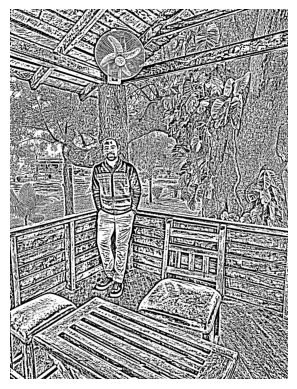

Displaying result for window size: 25


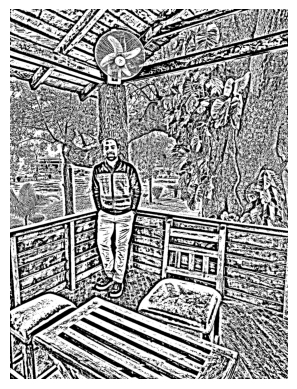

Displaying result for window size: 35


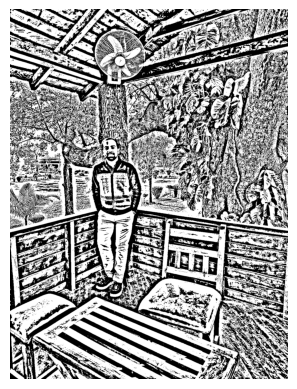

Displaying result for window size: 45


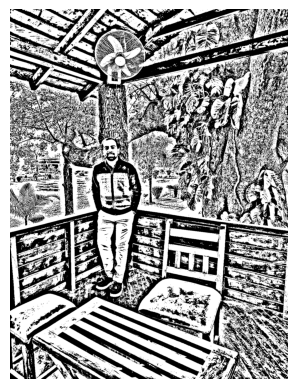

Best result with window size: 25


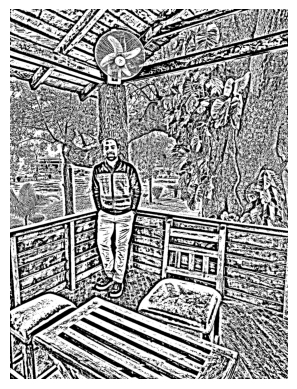

In [14]:
def niblack_threshold(image, window_size=15, k=-0.2):
    """
    Applies Niblack thresholding to an image.
    :param image: Grayscale image (numpy array)
    :param window_size: Size of the local window (must be an odd number)
    :param k: Niblack's parameter, usually between -0.2 and -0.5
    :return: Thresholded binary image
    """
    # Convert image to float for numerical stability
    image = image.astype(np.float32)

    # Compute mean and standard deviation in a local window
    mean = cv2.boxFilter(image, ddepth=-1, ksize=(window_size, window_size))
    mean_sq = cv2.boxFilter(image**2, ddepth=-1, ksize=(window_size, window_size))
    std_dev = np.sqrt(mean_sq - mean**2)

    # Compute Niblack threshold
    threshold = mean + k * std_dev

    # Apply threshold to create binary image
    binary_image = (image > threshold).astype(np.uint8) * 255

    return binary_image

# Load the image in grayscale
image = cv2.imread('selfie.jpg', cv2.IMREAD_GRAYSCALE)

# Experiment with different window sizes
window_sizes = [15, 25, 35, 45]

for size in window_sizes:
    binary_image = niblack_threshold(image, window_size=size, k=-0.2)
    print(f"Displaying result for window size: {size}")
    image_rgb = cv2.cvtColor(binary_image, cv2.COLOR_BGR2RGB)
    plt.imshow(image_rgb)
    plt.axis('off')  # Optional: turn off axis
    plt.show()

# Choose the best window size (for demonstration, assuming 25 is best)
best_window_size = 25
best_binary_image = niblack_threshold(image, window_size=best_window_size, k=-0.2)
print(f"Best result with window size: {best_window_size}")
i = cv2.cvtColor(best_binary_image, cv2.COLOR_BGR2RGB)
plt.imshow(i)
plt.axis('off')  # Optional: turn off axis
plt.show()


# **Question 2**

Displaying result for window size: 15


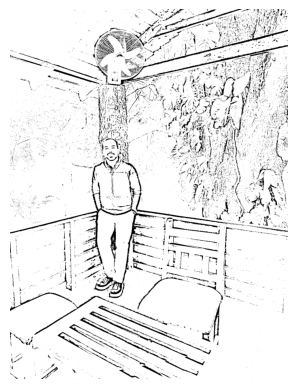

Displaying result for window size: 25


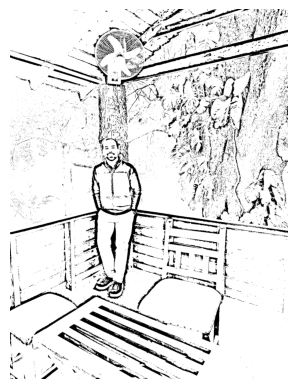

Displaying result for window size: 35


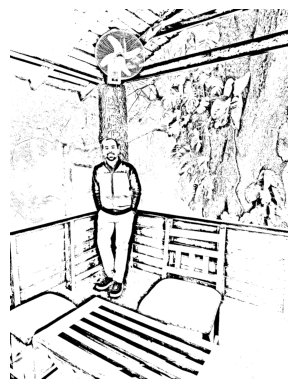

Displaying result for window size: 45


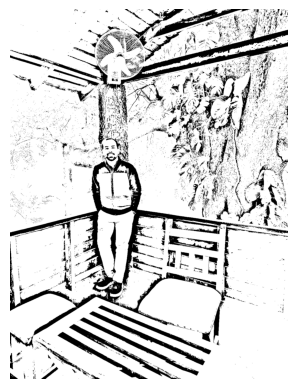

Best result with window size: 25


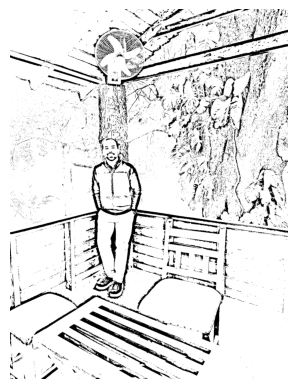

In [15]:
def sauvola_threshold(image, window_size=15, k=0.5, R=128):
    """
    Applies Sauvola thresholding to an image.
    :param image: Grayscale image (numpy array)
    :param window_size: Size of the local window (must be an odd number)
    :param k: Sauvola's parameter, usually 0.5
    :param R: Dynamic range of standard deviation, usually 128
    :return: Thresholded binary image
    """
    # Convert image to float for numerical stability
    image = image.astype(np.float32)

    # Compute mean and standard deviation in a local window
    mean = cv2.boxFilter(image, ddepth=-1, ksize=(window_size, window_size))
    mean_sq = cv2.boxFilter(image**2, ddepth=-1, ksize=(window_size, window_size))
    std_dev = np.sqrt(mean_sq - mean**2)

    # Compute Sauvola threshold
    threshold = mean * (1 + k * (std_dev / R - 1))

    # Apply threshold to create binary image
    binary_image = (image > threshold).astype(np.uint8) * 255

    return binary_image

# Load the image in grayscale
image = cv2.imread('selfie.jpg', cv2.IMREAD_GRAYSCALE)

# Experiment with different window sizes
window_sizes = [15, 25, 35, 45]

for size in window_sizes:
    binary_image = sauvola_threshold(image, window_size=size, k=0.5, R=128)
    print(f"Displaying result for window size: {size}")
    new_image = cv2.cvtColor(binary_image, cv2.COLOR_BGR2RGB)
    plt.imshow(new_image)
    plt.axis('off')  # Optional: turn off axis
    plt.show()

# Choose the best window size (for demonstration, assuming 25 is best)
best_window_size = 25
best_binary_image = sauvola_threshold(image, window_size=best_window_size, k=0.5, R=128)
print(f"Best result with window size: {best_window_size}")
i = cv2.cvtColor(best_binary_image, cv2.COLOR_BGR2RGB)
plt.imshow(i)
plt.axis('off')  # Optional: turn off axis
plt.show()


# **Question 3**

In [26]:
def preprocess_image(image_path):
    """Preprocess an image: grayscale, resize, blur, and threshold."""
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if image is None:
        raise FileNotFoundError(f"Error: Image '{image_path}' not found or cannot be read.")
    
    image = cv2.resize(image, (28, 28))  # Standard size for uniformity
    image = cv2.GaussianBlur(image, (3, 3), 0)  # Reduce noise
    # Adaptive thresholding using Otsu's method
    _, image = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    return image
# -> outputs going to be a 28x28 binary image 

def load_templates():
    """Load templates (handwritten digit samples 0-9)."""
    templates = {}
    for digit in range(10):
        digit_path = os.path.join("Sample", str(digit))
        image_list = [preprocess_image(os.path.join(digit_path, file)) 
                      for file in os.listdir(digit_path) if file.endswith(".png")]
        if not image_list:
            print(f"Warning: No templates found for digit {digit}")
        templates[digit] = image_list
    return templates

In [27]:
def zncc(template, image):
    """Compute Zero-mean Normalized Cross-Correlation (ZNCC) similarity."""
    template = template.astype(np.float32)
    image = image.astype(np.float32)
    mean_t = np.mean(template)
    mean_i = np.mean(image)
    numerator = np.sum((template - mean_t) * (image - mean_i))
    denominator = np.sqrt(np.sum((template - mean_t) ** 2) * np.sum((image - mean_i) ** 2))
    return numerator / denominator if denominator != 0 else 0

def match_digit(image, templates, method='zncc'):
    """Perform template matching using the specified similarity metric (default ZNCC)."""
    best_match = -1
    best_score = -1
    
    for digit, template_list in templates.items():
        for template in template_list:
            # Resize template to match test image size (if necessary)
            resized_template = cv2.resize(template, (image.shape[1], image.shape[0]))
            score = zncc(resized_template, image) if method == 'zncc' else 0
            if score > best_score:
                best_score = score
                best_match = digit
    return best_match

def knn_classify(test_image, train_templates, k=3):
    """
    Perform KNN classification using Euclidean distance.
    Compute the Euclidean distance between the flattened test image and each template.
    """
    distances = []
    for digit, template_list in train_templates.items():
        for template in template_list:
            resized_template = cv2.resize(template, (test_image.shape[1], test_image.shape[0]))
            dist = np.linalg.norm(test_image.flatten().astype(np.float32) - 
                                  resized_template.flatten().astype(np.float32))
            distances.append((dist, digit))
    
    # Sort distances in ascending order: lower distance means greater similarity
    distances.sort(key=lambda x: x[0])
    k_nearest = [d for _, d in distances[:k]]
    return max(set(k_nearest), key=k_nearest.count)  # Majority voting

def recognize_digit(image_path, method='zncc'):
    """Recognize a digit using template matching and KNN classification."""
    templates = load_templates()
    test_image = preprocess_image(image_path)
    
    match_result = match_digit(test_image, templates, method=method)
    knn_result = knn_classify(test_image, templates, k=3)
    
    return match_result, knn_result

In [30]:
if __name__ == "__main__":
    test_folder = "test"
    templates = load_templates()

    for filename in os.listdir(test_folder):
        if filename.endswith(".png"):
            image_path = os.path.join(test_folder, filename)
            try:
                test_image = preprocess_image(image_path)
                match = match_digit(test_image, templates, method='zncc')
                knn_class = knn_classify(test_image, templates, k=3)
                print(f" Test Image: {filename} | Template Matching: {match} | KNN Classification: {knn_class}")
            except FileNotFoundError as e:
                print(e)


 Test Image: 0.png | Template Matching: 0 | KNN Classification: 0
 Test Image: 1.png | Template Matching: 1 | KNN Classification: 1
 Test Image: 6.png | Template Matching: 6 | KNN Classification: 4
 Test Image: 8.png | Template Matching: 8 | KNN Classification: 8
 Test Image: 9.png | Template Matching: 9 | KNN Classification: 9


# **Question 4**

In [24]:
def show_image(image, title="Image", cmap="gray"):
    """Helper function to display an image using Matplotlib."""
    # If image has 3 channels, convert BGR to RGB.
    if len(image.shape) == 3 and image.shape[2] == 3:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(5, 5))
    plt.imshow(image, cmap=cmap)
    plt.title(title)
    plt.axis("off")
    plt.show()

def preprocess_card_image(image):
    print("[INFO] Converting image to grayscale...")
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    print("[INFO] Applying Gaussian blur...")
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    
    print("[INFO] Applying Otsu thresholding on the whole image...")
    _, thresh = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    
    # Display the images in a row using Matplotlib
    plt.figure(figsize=(15, 5))
    
    plt.subplot(1, 3, 1)
    plt.imshow(gray, cmap='gray')
    plt.title("Grayscale")
    plt.axis("off")
    
    plt.subplot(1, 3, 2)
    plt.imshow(blurred, cmap='gray')
    plt.title("Blurred")
    plt.axis("off")
    
    plt.subplot(1, 3, 3)
    plt.imshow(thresh, cmap='gray')
    plt.title("Otsu Threshold")
    plt.axis("off")
    
    plt.show()
    return gray, thresh

def refine_roi(roi):
    kernel_close = np.ones((3, 3), np.uint8)
    closed = cv2.morphologyEx(roi, cv2.MORPH_CLOSE, kernel_close)
    
    kernel_open = np.ones((3, 3), np.uint8)
    opened = cv2.morphologyEx(closed, cv2.MORPH_OPEN, kernel_open)
    
    return opened

def find_digit_contours(roi_thresh):
    print("[INFO] Finding contours...")
    cnts = cv2.findContours(roi_thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    
    if cnts:
        print(f"[INFO] Found {len(cnts)} contours, sorting them...")
        cnts = contours.sort_contours(cnts, method="left-to-right")[0]
    return cnts

def create_digit_templates():
    print("[INFO] Creating digit templates...")
    digit_templates = {}
    for i in range(10):
        template = np.zeros((50, 50), dtype="uint8")
        text = str(i)
        font = cv2.FONT_HERSHEY_SIMPLEX
        font_scale = 2.0
        thickness = 3
        
        # Get text size and center the text in the template.
        text_size = cv2.getTextSize(text, font, font_scale, thickness)[0]
        text_x = (template.shape[1] - text_size[0]) // 2
        text_y = (template.shape[0] + text_size[1]) // 2
        
        cv2.putText(template, text, (text_x, text_y), font, font_scale, 255, thickness)
        template_eq = cv2.equalizeHist(template)
        digit_templates[i] = template_eq
        
        # Display template for debugging (uncomment if needed)
        # show_image(template_eq, title=f"Template {i}", cmap='gray')
        
    print("[INFO] Digit templates created successfully.")
    return digit_templates

def match_digit(roi, templates):
    # Normalize ROI contrast.
    roi_eq = cv2.equalizeHist(roi)
    best_score = -1
    best_digit = -1
    for digit, template in templates.items():
        result = cv2.matchTemplate(roi_eq, template, cv2.TM_CCOEFF_NORMED)
        _, score, _, _ = cv2.minMaxLoc(result)
        if score > best_score:
            best_score = score
            best_digit = digit
    print(f"[DEBUG] Matched digit: {best_digit} with normalized score: {best_score:.2f}")
    return best_digit, best_score

def process_contour(contour, roi_thresh, templates):
    x, y, w, h = cv2.boundingRect(contour)
    recognized = []
    
    # Skip very small contours.
    if w * h < 50:
        return recognized
    
    digit_roi = roi_thresh[y:y+h, x:x+w]
    digit_roi = cv2.resize(digit_roi, (50, 50))
    digit, score = match_digit(digit_roi, templates)
    
    # Lower the acceptance threshold to 0.05 to include more digits.
    if score > 0.05:
        recognized.append((x, digit))
    
    return recognized

def recognize_credit_card_number(image_path):
    print(f"[INFO] Loading image: {image_path}")
    image = cv2.imread(image_path)
    
    if image is None:
        print("[ERROR] Image could not be loaded. Check the file path.")
        return None
    
    # Display original image
    show_image(image, title="Original Image", cmap='viridis')
    
    gray, global_thresh = preprocess_card_image(image)
    templates = create_digit_templates()
    
    # ROI coordinates 
    height, width = gray.shape
    start_x, end_x = int(width * 0.3), int(width * 0.95)
    start_y, end_y = int(height * 0.4), int(height * 0.65)
    
    print("[INFO] Extracting region of interest (ROI) for card number...")
    card_number_roi = global_thresh[start_y:end_y, start_x:end_x]
    
    show_image(card_number_roi, title="Card ROI (Thresholded)", cmap='gray')
    
    refined_roi = refine_roi(card_number_roi)
    show_image(refined_roi, title="Refined ROI", cmap='gray')
    
    cnts = find_digit_contours(refined_roi)
    
    # Draw bounding boxes for detected contours.
    roi_with_boxes = cv2.cvtColor(refined_roi.copy(), cv2.COLOR_GRAY2BGR)
    for c in cnts:
        x, y, w, h = cv2.boundingRect(c)
        cv2.rectangle(roi_with_boxes, (x, y), (x+w, y+h), (0, 255, 0), 1)
    
    show_image(roi_with_boxes, title="Detected Contours", cmap=None)
    
    recognized_digits = []
    print("[INFO] Processing detected contours...")
    for contour in cnts:
        recognized_digits.extend(process_contour(contour, refined_roi, templates))
    
    recognized_digits = sorted(recognized_digits, key=lambda item: item[0])
    card_number = ''.join(str(digit) for (_, digit) in recognized_digits)
    
    print(f"[INFO] Recognized Credit Card Number: {card_number}")
    return card_number


[INFO] Loading image: credit_card.png


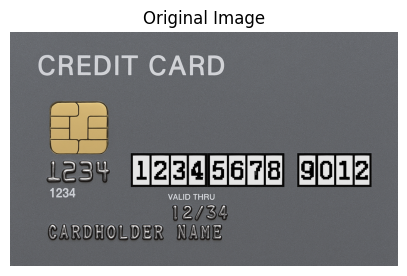

[INFO] Converting image to grayscale...
[INFO] Applying Gaussian blur...
[INFO] Applying Otsu thresholding on the whole image...


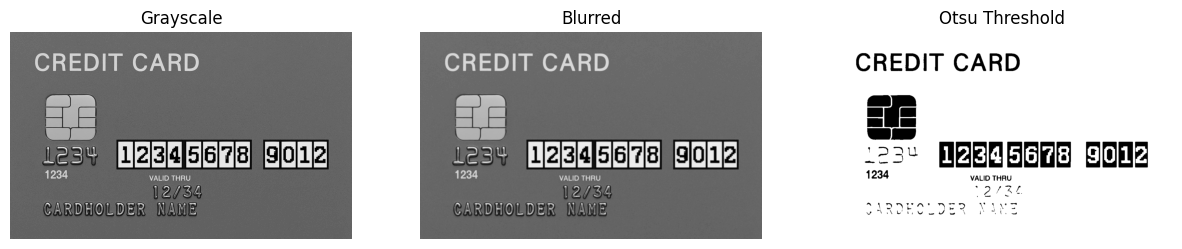

[INFO] Creating digit templates...
[INFO] Digit templates created successfully.
[INFO] Extracting region of interest (ROI) for card number...


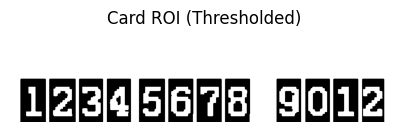

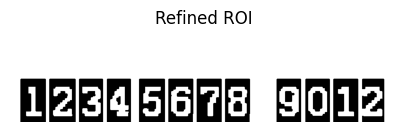

[INFO] Finding contours...
[INFO] Found 12 contours, sorting them...


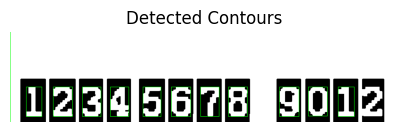

[INFO] Processing detected contours...
[DEBUG] Matched digit: 7 with normalized score: 0.03
[DEBUG] Matched digit: 1 with normalized score: 0.38
[DEBUG] Matched digit: 2 with normalized score: 0.28
[DEBUG] Matched digit: 3 with normalized score: 0.21
[DEBUG] Matched digit: 4 with normalized score: 0.30
[DEBUG] Matched digit: 5 with normalized score: 0.36
[DEBUG] Matched digit: 5 with normalized score: 0.30
[DEBUG] Matched digit: 7 with normalized score: 0.25
[DEBUG] Matched digit: 5 with normalized score: 0.26
[DEBUG] Matched digit: 9 with normalized score: 0.21
[DEBUG] Matched digit: 0 with normalized score: 0.18
[DEBUG] Matched digit: 1 with normalized score: 0.33
[INFO] Recognized Credit Card Number: 12345575901
Recognized Credit Card Number: 12345575901


In [25]:
if __name__ == "__main__":
    card_number = recognize_credit_card_number('credit_card.png')
    print(f"Recognized Credit Card Number: {card_number}")
    cv2.destroyAllWindows()
